# HCC case

In [2]:
from platform import python_version
print(python_version())

3.8.10


In [3]:
import numpy as np
import pandas as pd
import feyn

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from functions import model_features_chart, crossvalidation_as_framework

feyn._qlattice._USE_V2_API=True

In [4]:
feyn.__version__

'2.1.1'

In [5]:
# Load the data
data = pd.read_csv("../data/cancer_hcc.csv")

In [6]:
# Define the semantic types
stypes = {}
for f in data.columns:
    if data[f].dtype =='object':
        stypes[f] = 'c'
        
# Set random seed for reproducibility
random_seed = 42

# Define the target variable
target = "target"

In [7]:
### get the test data
random_seed = 42
train_val, test = train_test_split(data, test_size=0.2, stratify=data[target], random_state=random_seed)

## Set multifigure filename

In [18]:
filename = '../figures/hcc_mctaseq'

## In depth modelling 

In [19]:
projectname = 'hcc_mctaseq_epigenomics_'

In [20]:
pathname = '../figures'

In [27]:
### Get the test data
random_seed = 4
train_val, test = train_test_split(data, test_size=0.2, stratify=data[target], random_state=random_seed)

In [10]:
epochs = 50
criterion = 'bic'
max_complexity = 5
random_seed = 15
sw = np.where(train_val[target] == 1, np.sum(train_val[target] == 0)/sum(train_val[target]), 1)

In [60]:
ql = feyn.connect_qlattice(server="https://qlattice.stage.abzu.ai") # Connecting
ql.reset(random_seed) # Resetting
models_single = ql.auto_run(data = train_val,
                         output_name = target,
                         kind = "classification",
                         stypes = stypes,
                         n_epochs = epochs,
                         criterion=criterion,
                         max_complexity = max_complexity,
                         sample_weights=sw)

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="216.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 611 216.0" width="611" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="351" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="241" y="50.0"><title>target
logistic:
w=-7.6027
bias=0.4842</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="71.5">target</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="243" y="59.0">out</text><line stroke="#1E1E1E" x1="211" x2="241" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="50.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="71.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="59.0">1</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="76.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>chr17_59473060_59483266
linear:
scale=0.002112
scale offset=145.125000
w=-6.575776
bias=-0.3834</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">chr17_59..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>chr3_9987895_9989619
linear:
scale=0.008097
scale offset=116.125000
w=2.043891
bias=-0.1456</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="101.5">chr3_998..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="89.0">3</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="89.0">num</text></svg><svg class="summary" height="79" width="180" x="351" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="0" y="14">Training Metrics</text><line stroke="#1E1E1E" x1="0" x2="160" y1="19" y2="19" /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="34">Accuracy</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="34">0.958</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="49">AUC</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="49">0.997</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="64">Precision</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="64">0.931</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="79">Recall</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="79">0.964</text></svg><svg class="summary" height="79" width="80" x="531" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" te
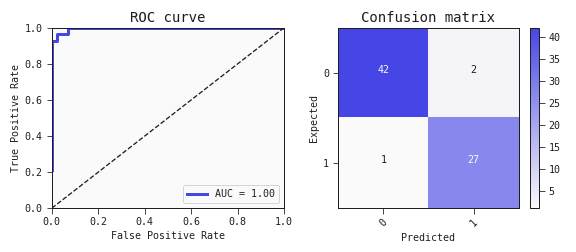
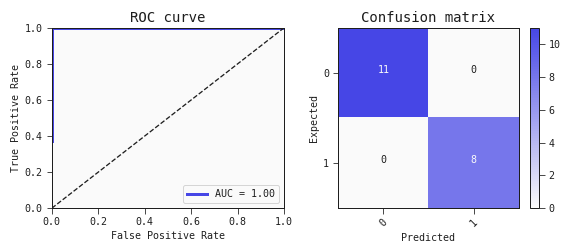

In [61]:
models_single[0].plot(train_val,test)

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="232.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 741 232.0" width="741" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="471" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="361" y="50.0"><title>target
logistic:
w=9.4766
bias=2.2005</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="71.5">target</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="363" y="59.0">out</text><line stroke="#1E1E1E" x1="331" x2="361" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="50.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="71.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="59.0">1</text><line stroke="#1E1E1E" x1="211" x2="241" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="76.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="121" y="20.0"><title>chr6_158507719_158508126
linear:
scale=0.005814
scale offset=134.736111
w=-9.512510
bias=-5.4644</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="41.5">chr6_158..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="29.0">2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="123" y="29.0">num</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="80.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="101.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="89.0">3</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="88.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="106.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>chr3_138724325_138725446
linear:
scale=0.005222
scale offset=265.611111
w=0.846973
bias=0.3712</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">chr3_138..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">4</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>chr17_59473060_59483266
linear:
scale=0.002112
scale offset=145.125000
w=-5.137336
bias=-0.8334</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="101.5">chr17_59..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="89.0">5</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="89.0">num</text></svg><svg class="summary" height="79" width="1
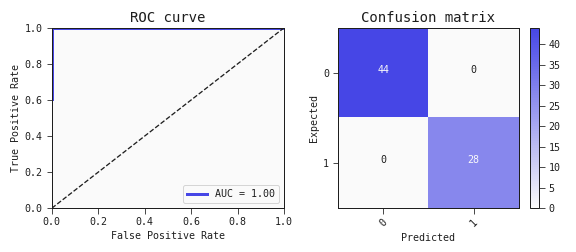
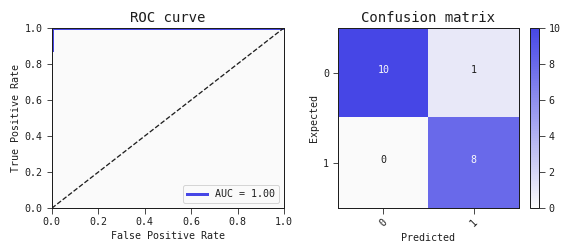

In [62]:
models_single[1].plot(train_val,test)

In [63]:
def modsum(models, train, test):
 model_list=[]
 auc_list_train=[]
 auc_list_test=[]
 bic_list=[]
 feat_list=[]
 loss_list=[]
 i=0
 for x in models:
     model_list.append(str(i))
     auc_list_train.append(str(x.roc_auc_score(train).round(2)))
     auc_list_test.append(str(x.roc_auc_score(test).round(2)))
     bic_list.append(str(x.bic.round(2)))
     feat_list.append(len(x.features))
     loss_list.append(x.loss_value)
     i+=1
 df = pd.DataFrame(list(zip(model_list, auc_list_train, auc_list_test, bic_list, feat_list, loss_list)),
               columns =['Models', 'AUC Train', 'AUC Test','BIC','NumFeatures','Loss'])
 return(df)    

In [64]:
modsum(models_single, train_val, test)

,Models,AUC Train,AUC Test,BIC,NumFeatures,Loss
0,0,1.0,1.0,15.67,2,0.079100
1,1,1.0,1.0,16.88,3,0.028104
2,2,1.0,1.0,16.9,3,0.028237
3,3,1.0,0.9,19.19,3,0.014493
4,4,1.0,1.0,19.53,2,0.076199
5,5,1.0,0.88,19.78,3,0.018538
6,6,1.0,1.0,20.66,3,0.054373
7,7,1.0,1.0,21.0,3,0.086423
8,8,1.0,1.0,23.71,3,0.075559
9,9,0.99,0.98,23.81,2,0.105958


In [65]:
feature_plot_hcc_mctaseq = model_features_chart(test, models_single, metric="roc_auc_score")
model_features_chart(test, models_single, metric="roc_auc_score")

,agreement,roc_auc_score,chr17_59473060_59483266,chr11_17756056_17758286,chr3_9987895_9989619,chr5_139525537_139526227,chr14_54430154_54430670,chr6_158507719_158508126,chr6_87832219_87832610,chr1_45271679_45272318,chr1_1374461_1375584,chr16_2139803_2142170,chr5_176023777_176024651,chr1_221050448_221050864,chr8_145103285_145108027,chr5_464887_465666,chr1_27901660_27902688,chr3_138724325_138725446
Model#,,,,,,,,,,,,,,,,,,
1,1.000000,1.000000,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True
2,0.947368,1.000000,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False
4,0.947368,1.000000,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,0.894737,1.000000,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
7,0.894737,1.000000,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False
8,0.789474,1.000000,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False
0,1.000000,1.000000,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
9,0.947368,0.977273,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,0.842105,0.897727,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [66]:
feature_plot_hcc_mctaseq.to_excel('HCC_QLattice_feature_plot_hcc_mctaseq_autorun_251121.xlsx')

ModuleNotFoundError: No module named 'openpyxl'

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="216.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 611 216.0" width="611" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="351" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="241" y="50.0"><title>target
logistic:
w=-7.6027
bias=0.4842</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="71.5">target</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="243" y="59.0">out</text><line stroke="#1E1E1E" x1="211" x2="241" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="50.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="71.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="59.0">1</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="76.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>chr17_59473060_59483266
linear:
scale=0.002112
scale offset=145.125000
w=-6.575776
bias=-0.3834</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">chr17_59..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>chr3_9987895_9989619
linear:
scale=0.008097
scale offset=116.125000
w=2.043891
bias=-0.1456</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="101.5">chr3_998..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="89.0">3</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="89.0">num</text></svg><svg class="summary" height="79" width="180" x="351" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="0" y="14">Training Metrics</text><line stroke="#1E1E1E" x1="0" x2="160" y1="19" y2="19" /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="34">Accuracy</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="34">0.958</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="49">AUC</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="49">0.997</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="64">Precision</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="64">0.931</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="79">Recall</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="79">0.964</text></svg><svg class="summary" height="79" width="80" x="531" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" te
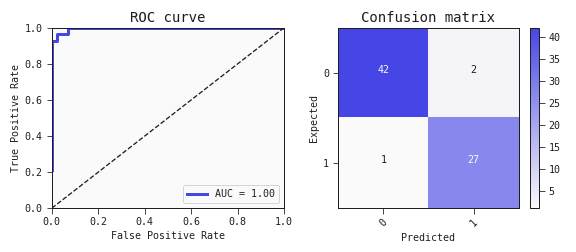
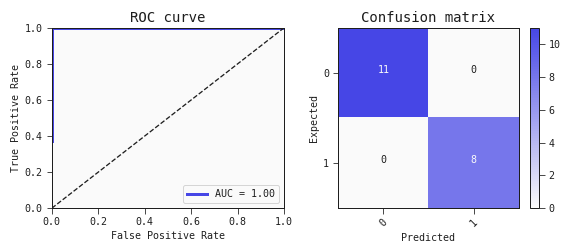

In [67]:
models_single[0].plot(train_val,test)

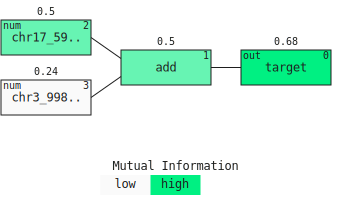

In [68]:
models_single[0].plot_signal(test, corr_func='mutual_information')

In [69]:
sympy_model = models_single[0].sympify(symbolic_lr = True, signif=3)
sympy_model.as_expr()

1/(0.0225*exp(-0.106*chr175947306059483266 + 0.126*chr399878959989619) + 1)

In [70]:
features_data = train_val[models_single[0].features + ["target"]]

In [71]:
import seaborn as sns
# Pairplot with target coloring
sns.pairplot(features_data, hue = 'target')

ModuleNotFoundError: No module named 'seaborn'

In [72]:
# Plot a 2-dimensional partial plot
## models_single[0].plot_response_2d(train_val[models_single[0].features])

# Cross-validation as a framework

In [11]:
from _crossvalidation import crossvalidation_as_framework

In [12]:
results = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = epochs,
                                     criterion=criterion,
                                     max_complexity = max_complexity)

In [20]:
# average performance of first 10 models
results.roc_auc_val.mean(), results.accuracy_val.mean(), results.groupby("fold").first().roc_auc_val.mean(), results.groupby("fold").first().accuracy_val.mean()

(0.8925974025974025,
 0.8435087719298244,
 0.8837662337662338,
 0.8134502923976609)

In [19]:
# average performance of first model
results.groupby("model_structure").first().roc_auc.mean(), results.groupby("model_structure").first().accuracy.mean()

AttributeError: 'DataFrame' object has no attribute 'roc_auc'

# Best model according to CV:

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="216.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 621 216.0" width="621" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="351" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="241" y="50.0"><title>target
logistic:
w=-7.3979
bias=-0.9960</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="71.5">target</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="243" y="59.0">out</text><line stroke="#1E1E1E" x1="211" x2="241" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="50.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="71.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="59.0">1</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="76.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>chr19_13207375_13207621
linear:
scale=0.026667
scale offset=16.051724
w=-4.910231
bias=-0.0717</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">chr19_13..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>chr3_9987895_9989619
linear:
scale=0.008097
scale offset=116.534483
w=2.007018
bias=-0.6945</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="101.5">chr3_998..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="89.0">3</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="89.0">num</text></svg><svg class="summary" height="79" width="180" x="351" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="0" y="14">Training Metrics</text><line stroke="#1E1E1E" x1="0" x2="160" y1="19" y2="19" /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="34">Accuracy</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="34">0.958</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="49">AUC</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="49">0.994</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="64">Precision</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="64">0.963</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="79">Recall</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="79">0.929</text></svg><svg class="summary" height="79" width="90" x="531" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" te
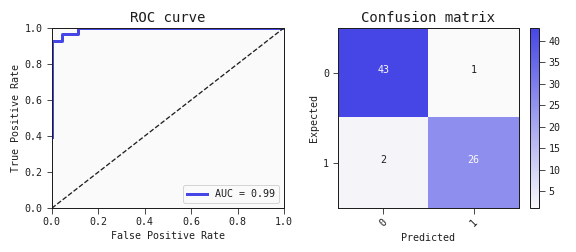
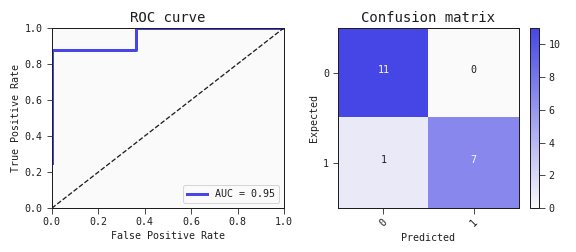

In [32]:
models_single[1].plot(train_val,test)

In [33]:
models_single[1].plot(train_val,test,filename="HCC_QLattice_BestCVModel.html")

'/home/niels/manuscript_abzu/manuscript_AD_HCC_notebooks/notebooks/HCC_QLattice_BestCVModel.html'

In [34]:
best = models_single[1]

In [35]:
features_data = train_val[best.features + ["target"]]

In [36]:
# Make a copy of this:
features_data_copy = features_data.copy()

In [37]:
columns_titles = [features_data.columns[1],features_data.columns[0]]
features_data_copy=features_data_copy.reindex(columns=columns_titles)

In [38]:
features_data_copy["target"]=features_data["target"]

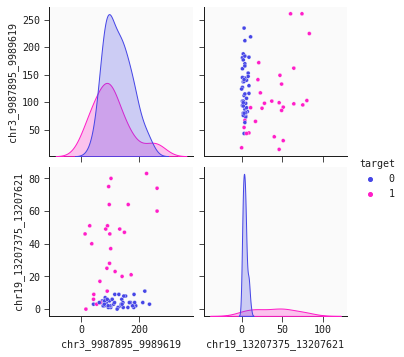

In [39]:
# Pairplot with target coloring
sns.pairplot(features_data_copy, hue = 'target').savefig('HCC_seaborn_plot_031121.png')

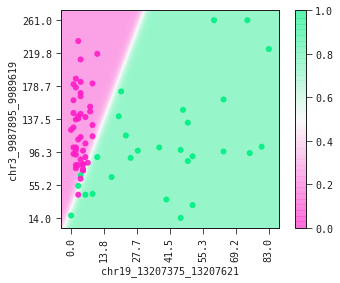

In [43]:
best.plot_response_2d(train_val,filename="hcc_response_2d_031121")

In [44]:
df_cv.to_excel('hcc_mctaseq_CV_031121.xlsx')

In [45]:
def save_cv_results(df_results, filename = "tmp"):
    df_results.to_csv(filename + ".csv", index = False)
    i = 0
    for m in df_results.model:
        m.save(filename + "_" + str(i) + ".graph")
        i += 1

In [46]:
save_cv_results(df_cv, 'hcc_cv_031121')

# Correlation plot for article

In [47]:
best = models_single[1]

In [48]:
best.features

['chr19_13207375_13207621', 'chr3_9987895_9989619']

In [49]:
import seaborn as sns

In [50]:
# Take a random subset of 100 features
data_wo_target = data.drop('target', axis = 1)
sampled_features = np.unique(list(np.random.choice(data_wo_target.columns, 100, replace=False)) + best.features)
sample_data = data[sampled_features]

In [51]:
# Prepare for labelling the two model features in the heatmap
label_feature = list()

for x, i in enumerate(sampled_features):
    if i in best.features:
        label_feature.append(1)
    else: label_feature.append(0)

# Assign colors to chosen features
lut = dict({0: 'w',
           1: 'b'})

# Map colors to correlation data
row_coloring = pd.Series(label_feature, index = sample_data.corr().index).map(lut)

/home/niels/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


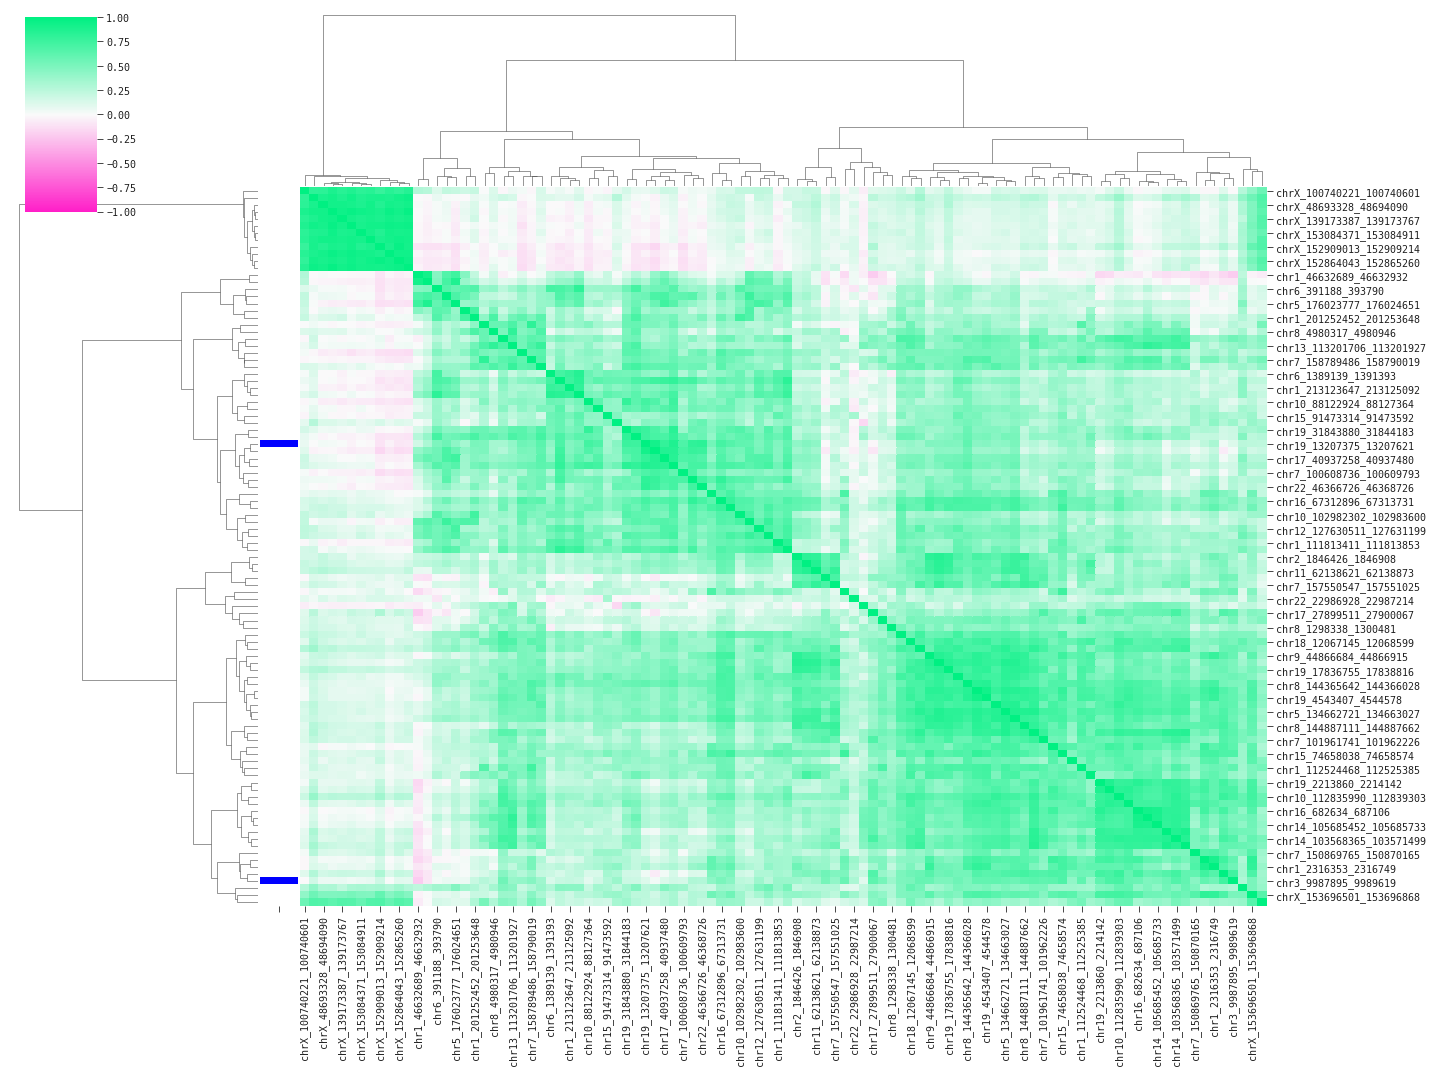

In [52]:
p = sns.clustermap(sample_data.corr(), method="ward", cmap='feyn-diverging', row_colors = row_coloring,
               vmin=-1, vmax=1, figsize=(20,15), robust=False)

In [53]:
p.savefig("HCC_seaborn_corrmap_031121.png")

In [54]:
pwd

'/home/niels/manuscript_abzu/manuscript_AD_HCC_notebooks/notebooks'

# Additional plots for article

In [55]:
sympy_model = best.sympify(symbolic_lr = True, signif=3)
sympy_model.as_expr()

1/(0.0436*exp(-0.969*chr191320737513207621 + 0.12*chr399878959989619) + 1)